<a href="https://colab.research.google.com/github/jhermosillo/DIPLOMADO_CDP/blob/main/Modulo%205%20-%20Deep%20Leaning/code/DL_08_B_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Trains a sentiment analysis model to classify movie reviews as positive or negative, based on the text of the review.
# https://www.tensorflow.org/tutorials/text/classify_text_with_bert
# https://analyticsindiamag.com/bert-classifier-with-tensorflow-2-0/
#
# EXAMPLE: https://stackabuse.com/text-classification-with-bert-tokenizer-and-tf-2-0-in-python/
# Data: https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

# Section 0: Not used. Only here to show another way to load data

In [ ]:
# Load data and remove empty entries
movie_reviews = pd.read_csv("IMDB_Dataset.csv")
movie_reviews.dropna(inplace=True)
movie_reviews

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [ ]:
# Cleaning
TAG_RE = re.compile(r'<[^>]+>')
def preprocess_text(sen):
  """
  """
  sentence = TAG_RE.sub('', sen) # html tags
  sentence = re.sub('[^a-zA-Z]', ' ', sentence) # punctuations and numbers
  sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence) # single character
  sentence = re.sub(r'\s+', ' ', sentence) # multiple spaces
  return sentence

In [ ]:
# Clean and preprocess text
sentences = list(movie_reviews['review'])
reviews = [preprocess_text(sen) for sen in sentences]

print(len(reviews))
reviews[:5]

50000


['One of the other reviewers has mentioned that after watching just Oz episode you ll be hooked They are right as this is exactly what happened with me The first thing that struck me about Oz was its brutality and unflinching scenes of violence which set in right from the word GO Trust me this is not show for the faint hearted or timid This show pulls no punches with regards to drugs sex or violence Its is hardcore in the classic use of the word It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary It focuses mainly on Emerald City an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda Em City is home to many Aryans Muslims gangstas Latinos Christians Italians Irish and more so scuffles death stares dodgy dealings and shady agreements are never far away would say the main appeal of the show is due to the fact that it goes where other shows wouldn dare Forget pretty pictur

In [ ]:
# Put sentiments into class form {0, 1}
y = movie_reviews['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

print(len(y))
print(y[:20])

50000
[1 1 1 0 1 1 1 0 0 1 0 0 0 0 1 0 1 0 1 0]


# Section 1: install libraries and import them

In [1]:
# Install some dependencies
!pip install -q tensorflow-text  # A dependency of the preprocessing for BERT inputs
!pip install -q tf-models-official # For the AdamW optimizer from tensorflow/models
!pip install bert-for-tf2
!pip install sentencepiece

     |████████████████████████████████| 4.3MB 7.8MB/s 
     |████████████████████████████████| 1.6MB 8.6MB/s 
     |████████████████████████████████| 1.2MB 35.7MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
     |████████████████████████████████| 51kB 9.2MB/s 
     |████████████████████████████████| 686kB 45.9MB/s 
     |████████████████████████████████| 38.2MB 86kB/s 
     |████████████████████████████████| 215kB 51.8MB/s 
     |████████████████████████████████| 358kB 48.8MB/s 
     |████████████████████████████████| 645kB 37.2MB/s 
     |████████████████████████████████| 102kB 15.2MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-cp37-none-any.whl size=30535 sha256=125363317c373f7708335f72f172734919187e01d227c33c472104474c3d2f3b
  Stored in directory: /root/.cache/pip/wheels/a1/04/ee/347bd9f5b821b637c76411d280271a857aece00358896a230f
  Created wheel for py-params: filename=py_params-0.10.2-cp37-none

In [2]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer
tf.get_logger().setLevel('ERROR')

# Load data from online repo

In [3]:
# Download dataset
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url, untar=True,
                                  cache_dir='.', cache_subdir='')

# Define root and train directory
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

# see what is in the directories
print(os.listdir(dataset_dir))
print(os.listdir(train_dir))

84131840/84125825 [==============================] - 1s 0us/step
['README', 'train', 'imdbEr.txt', 'test', 'imdb.vocab']
['neg', 'pos', 'labeledBow.feat', 'unsupBow.feat', 'urls_pos.txt', 'urls_unsup.txt', 'urls_neg.txt']


In [4]:
# Set some parameters
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

In [5]:
# Create a DataSet object to fetch training batches
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [6]:
# See a few examples
class_names = raw_train_ds.class_names 
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

In [7]:
# Create a DataSet object to fetch validation batches
val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [8]:
# Create a DataSet object to fetch test batches from
test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.


# Section 2: Load preprocessing and embedding layers of BERT, and show their use on a dummy sentence

In [9]:
# BERT has several sub-models
# Look at https://www.tensorflow.org/tutorials/text/classify_text_with_bert
# or at github repo for different options
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
# Get the preprocessing BERT layer from the selected model
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

# Use it in a sample text
text_test = ['This is a dummy and boring phrase!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101  2023  2003  1037 24369  1998 11771  7655   999   102     0     0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
# Get the embedding BERT layer from the selected model
bert_model = hub.KerasLayer(tfhub_handle_encoder)

# Use it on a sample text
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Keys       : {list(bert_results.keys())}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Keys       : ['sequence_output', 'default', 'pooled_output', 'encoder_outputs']
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.858383    0.9929618  -0.44112456  0.1829921  -0.05537977  0.6960504
  0.9822458  -0.9680905  -0.36053067 -0.98947084 -0.05730482 -0.9754773 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.4644812   0.43961537  0.11124045 ... -0.07349271  0.45497283
  -0.7253016 ]
 [-0.14757243  0.3121541   0.01162594 ...  0.45004845 -0.72692066
   0.14865153]
 [-0.4308794   0.7181751  -0.8244211  ... -0.19767302 -0.94411653
   0.06614166]
 ...
 [-0.17440607 -0.04706343  0.3422734  ... -0.5582918   1.0463561
  -0.28744692]
 [ 0.01745122  0.09584316  0.04619433 ...  0.409       0.7588208
  -0.10293103]
 [-0.09262282  0.08405627 -0.06823236 ...  0.376357    0.69862837
  -0.22296624]]


# Section 3: Create a DL model, train it, and use it for inference

In [ ]:
# Build Neural Network with BERT
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)

encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)

net = outputs['pooled_output']
net = tf.keras.layers.Dropout(0.1)(net)
net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)

classifier_model = tf.keras.Model(text_input, net)
classifier_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_mask': (None 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'pooled_output': (N 28763649    preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
____________________________________________________________________________________________

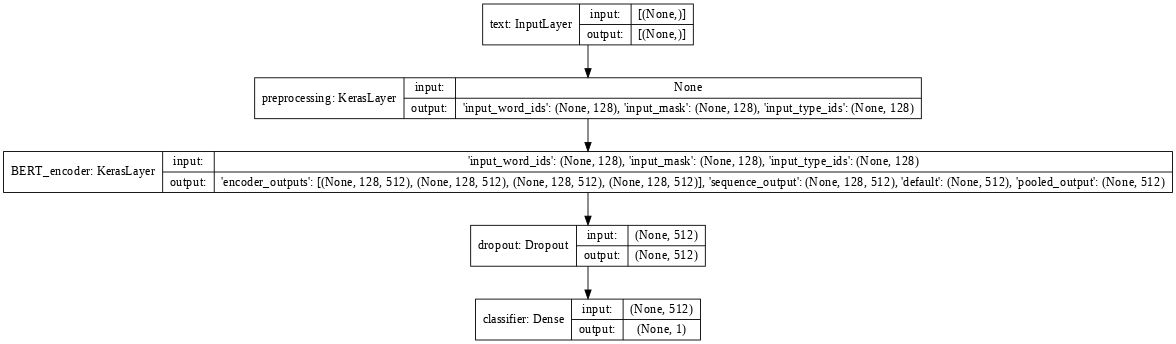

In [ ]:
# Plot it
tf.keras.utils.plot_model(classifier_model, show_shapes=True, show_layer_names=True, dpi=64)

In [ ]:
# Custom compilation
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

classifier_model.compile(optimizer=optimizer,
                         loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                         metrics=tf.metrics.BinaryAccuracy())

In [ ]:
# Training
history = classifier_model.fit(x=train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5
625/625 [==============================] - 159s 246ms/step - loss: 0.5908 - binary_accuracy: 0.6469 - val_loss: 0.3896 - val_binary_accuracy: 0.8380
Epoch 2/5
625/625 [==============================] - 151s 242ms/step - loss: 0.3665 - binary_accuracy: 0.8335 - val_loss: 0.3761 - val_binary_accuracy: 0.8468
Epoch 3/5
625/625 [==============================] - 151s 242ms/step - loss: 0.2784 - binary_accuracy: 0.8797 - val_loss: 0.3950 - val_binary_accuracy: 0.8486
Epoch 4/5
625/625 [==============================] - 151s 242ms/step - loss: 0.2108 - binary_accuracy: 0.9137 - val_loss: 0.4467 - val_binary_accuracy: 0.8506
Epoch 5/5
625/625 [==============================] - 151s 241ms/step - loss: 0.1653 - binary_accuracy: 0.9356 - val_loss: 0.4760 - val_binary_accuracy: 0.8532


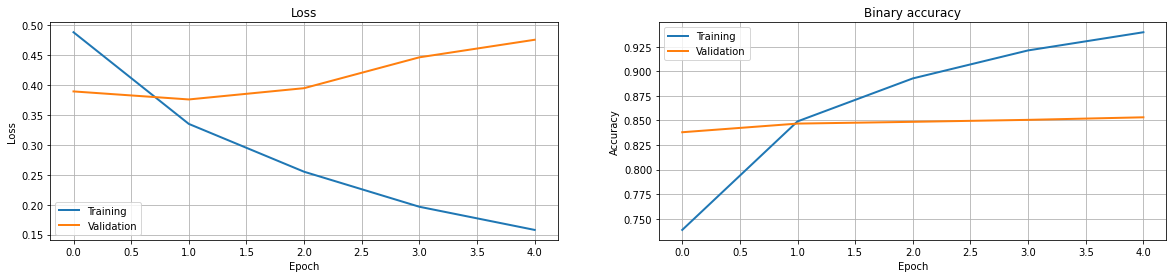

In [ ]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Binary accuracy')
plt.plot(history.history['binary_accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_binary_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [ ]:
# Evaluate on test set
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 89s 114ms/step - loss: 0.4570 - binary_accuracy: 0.8556
Loss: 0.4570128917694092
Accuracy: 0.8556399941444397


In [ ]:
# Evaluate on short easy examples
examples = [
    'this is such an amazing movie!',
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...']

results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results:')
results = [f'input: {examples[i]:<30} : score: {results[i][0]:.6f}' for i in range(len(results))]
print(*results, sep='\n')

Results:
input: this is such an amazing movie! : score: 0.999464
input: The movie was great!           : score: 0.995682
input: The movie was meh.             : score: 0.959475
input: The movie was okish.           : score: 0.020914
input: The movie was terrible...      : score: 0.000697
